In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import base64
from io import BytesIO
import plotly.express as px

## preprocess DP and SF1 data

In [ ]:
#process PD data
st = pd.HDFStore('2010dp.h5', complib='zlib', complevel=5 )

dp_folder = '2010_dp/'
geowidth= [6,2,3,2,3,2,7,1,1,2,3,2,2,5,2,2,5,2,2,6,1,4]
geoflds= ['FILEID','STUSAB','SUMLEV','GEOCOMP','CHARITER', 'CIFSN','LOGRECNO','REGION','DIVISION' ,'STATE' ,'COUNTY' ,
                'COUNTYCC' ,'COUNTYSC' ,'COUSUB' ,'COUSUBCC' ,'COUSUBSC' , 'PLACE' ,'PLACECC' ,'PLACESC' ,'TRACT' ,'BLKGRP' ,'BLOCK']
dfdata = pd.read_fwf(dp_folder + 'migeo2010.dhc', widths =geowidth, names = geoflds, header = None, usecols = range(22))


dp_files = {'Segment1_demographicAndHousehold.csv':'mi000012010.dhc',
                'Segment2_householdAndGQ.csv':'mi000022010.dhc',
                'Segment14_housing.csv':'mi000142010.dhc' }
for k in dp_files.keys():               
    headers = pd.read_csv(dp_folder + k)
    headers = list(headers.columns)[4:]
    print(len(headers))
    data = pd.read_csv(dp_folder + dp_files[k], header=None, usecols = range(4, len(headers) + 4))
    print(data.shape)
    data.columns = headers
    
    dfdata = pd.merge(dfdata, data, left_on = 'LOGRECNO', right_on = 'LOGRECNO', how='left')

st['dp_2010']= dfdata
st.close()

In [ ]:
st = pd.HDFStore('2010sf1.h5', complib='zlib', complevel=5)

sf1_folder = '2010_sf1_sel/'
dfdata = pd.read_csv(sf1_folder + 'GEO_HEADER_SF1.txt', usecols = range(22))

sf1_files = ['SF1_00001.txt','SF1_00002.txt','SF1_00003.txt','SF1_00004.txt','SF1_00005.txt','SF1_00044.txt']
for f in sf1_files:
    print(f)               
    data = pd.read_csv(sf1_folder + f)
    data.drop(['FILEID','STUSAB','CHARITER','CIFSN'], axis=1,inplace=True)
    dfdata = pd.merge(dfdata, data, left_on = 'LOGRECNO', right_on = 'LOGRECNO', how='left')

data = pd.read_csv(sf1_folder + 'SF1_00006mod.csv')
dfdata = pd.merge(dfdata, data, left_on = 'LOGRECNO', right_on = 'LOGRECNO', how='left')

st['sf1_2010'] = dfdata
st.close()

## extract Table by name and sumlevel

In [4]:
stdp = pd.HDFStore('2010dp.h5', 'r' )
stsf1 = pd.HDFStore('2010sf1.h5', 'r' )

In [5]:
#build a lookup table table-> field, so it can be used to extract data by table id
# vlist = [col for col in stdp['/dp_2010'].columns if '0' in col ]
# tlist = [[col[:-3].replace('0',''), col] for col in vlist]
# tlookup = pd.DataFrame(tlist, columns=['table', 'code'])
# tlookup = tlookup.set_index('table')

In [6]:
#build an field name lookup table, so the plot can use name instead of field code
sf1_folder = '2010_sf1_sel/'
df_lookup = pd.read_excel(sf1_folder + 'SelectVariablesToCompare.xlsx')
df_lookup.dropna(axis =0, inplace = True)
tbl_lookup = df_lookup[['TABLE NUMBER', 'FIELD CODE']].set_index('TABLE NUMBER')
name_lookup = df_lookup[['FIELD CODE', 'FIELD NAME']].set_index('FIELD CODE')


In [7]:
def pct_dif(df1, df2):
    df_diff = df2.subtract(df1, axis =1)
    df_pct_diff = df_diff.div(df1, axis=1) * 100.0
    df_pct_diff.update(df_diff[df_diff==0])
    df_pct_diff = df_pct_diff.replace([np.inf, -np.inf],np.nan).dropna(axis=0)
    return df_pct_diff

In [8]:
def dif_summary(df_dif):
    dfp = pd.DataFrame(data=[df_dif.mean(), df_dif.std(), df_dif.min(), df_dif.max()]).T
    dfp.columns = ['mean', 'std', 'min', 'max']
        #plt.gca().invert_yaxis()
    dfp = dfp.sort_index(axis = 0, ascending = False)
    return dfp

In [9]:
def errorbars(df, plot_folder, plot_name):

    sns.set(font_scale=1.5)
    plt.figure(figsize = (10, max(5, len(df)/1.5)))

    plt.rcParams.update({'font.size': 24})

    plt.vlines(0, 0, len(df))
    plt.errorbar(df['mean'], range(len(df.index)), xerr= [df['mean'] - df['min'], df['max'] - df['mean']],
                fmt='ok', ecolor='gray', lw=1, capsize=8)
    plt.errorbar(df['mean'], range(len(df.index)), xerr=df['std'], fmt='ok', lw=4)
    for (x,y,l) in zip(df['mean'],  range(len(df.index)), round(df['mean'],3)):
        plt.text(50, y + 0.1, l, size=14)
    plt.xticks()
    plt.yticks(range(len(df.index)), list(df.index))
    plt.title(plot_name + ' PCT Block Group Errors')

    plt.tight_layout()

    plt.savefig(plot_folder + plot_name + '_error.png')
    print('save plot to ' +plot_folder + plot_name + '_error.png')
    return plt

In [10]:
def histo_plot(df, plot_folder, plot_name, plot):
    sns.set()

    html = """<!DOCTYPE html>  <html>
        <head> <title>%s</title> </head> <body>
    """ % "_".join([plot_name, '_histograms'])

    tmpfile = BytesIO()
    plot.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    html = html + '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    plot.clf()

    for dif in df.columns:
        ax = df[dif].hist(bins=100, xlabelsize =15, ylabelsize =15, figsize =(9,6))
        fig = ax.get_figure()
        fig.suptitle(dif, fontsize =22 )

        tmpfile = BytesIO()
        fig.savefig(tmpfile, format='png')
        encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
        html = html + '<img src=\'data:image/png;base64,{}\'>'.format(encoded)

        fig.clf()

    html = html + """</body> </html>"""
    with open(plot_folder + "_".join([plot_name, '_histograms.html']),'w') as f:
        f.write(html)

In [13]:
dfdif.head()

NameError: name 'dfdif' is not defined

In [ ]:
histo_plot(dfdif, 'plots/', t)

In [11]:
df = px.data.iris()

In [12]:
fig = px.scatter(df, x="sepal_width", y="sepal_length")

sepal_length  sepal_width  petal_length  petal_width    species  \
0             5.1          3.5           1.4          0.2     setosa   
1             4.9          3.0           1.4          0.2     setosa   
2             4.7          3.2           1.3          0.2     setosa   
3             4.6          3.1           1.5          0.2     setosa   
4             5.0          3.6           1.4          0.2     setosa   
..            ...          ...           ...          ...        ...   
145           6.7          3.0           5.2          2.3  virginica   
146           6.3          2.5           5.0          1.9  virginica   
147           6.5          3.0           5.2          2.0  virginica   
148           6.2          3.4           5.4          2.3  virginica   
149           5.9          3.0           5.1          1.8  virginica   

     species_id  
0             1  
1             1  
2             1  
3             1  
4             1  
..          ...  
145           3  
146           3  
147           3  
148           3  
149           3  

[150 rows x 6 columns]

In [ ]:
errorbars(dfp, 'plots/', t)

In [14]:
geoids = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP']
level = 150
dp_2010 = stdp['/dp_2010'].loc[stdp['/dp_2010'].SUMLEV ==level]
sf1_2010 = stsf1['/sf1_2010'].loc[stsf1['/sf1_2010'].SUMLEV ==level]

for t in tbl_lookup.index.unique():
    print(t)
    vcodes = list(tbl_lookup.loc[[t]]['FIELD CODE'])
    dpdata = dp_2010[geoids + vcodes ]
    sf1data = sf1_2010[geoids + vcodes]

    dpdata =  dpdata.set_index(geoids)
    sf1data =  sf1data.set_index(geoids)

    print('make diff...')
    dfdif = pct_dif(sf1data, dpdata)
    dfp = dif_summary(dfdif)
    dfp.index=name_lookup.loc[dfp.index, 'FIELD NAME']
    print('plot...')
    plot1 = errorbars(dfp, 'plots/', t)
    histo_plot(dfdif, 'plots/', t, plot1 )

P1
make diff...
plot...
save plot to plots/P1_error.png
P5
make diff...
plot...
save plot to plots/P5_error.png
P12
make diff...
plot...
save plot to plots/P12_error.png
P13
make diff...
plot...
save plot to plots/P13_error.png
P15
make diff...
plot...
save plot to plots/P15_error.png
P16
make diff...
plot...
save plot to plots/P16_error.png
P18
make diff...
plot...
save plot to plots/P18_error.png
P22
make diff...
plot...
save plot to plots/P22_error.png
P25
make diff...
plot...
save plot to plots/P25_error.png
P28
make diff...
plot...
save plot to plots/P28_error.png
P43
make diff...
plot...
save plot to plots/P43_error.png
H3
make diff...
plot...
save plot to plots/H3_error.png
H7
make diff...
plot...
save plot to plots/H7_error.png
H10
make diff...
plot...
save plot to plots/H10_error.png
H13
make diff...
plot...
save plot to plots/H13_error.png


<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

In [15]:
sf1data

H0130001  H0130002  H0130003  H0130004  \
STATE COUNTY TRACT    BLKGRP                                           
26    1.0    100.0    1.0          342       115       193        19   
                      2.0          553       157       280        50   
             970100.0 1.0          536       155       258        56   
                      2.0          646       205       308        59   
             970400.0 1.0          611       170       251        84   
...                                ...       ...       ...       ...   
      165.0  380700.0 2.0          493       127       176        80   
                      3.0          311       146        91        31   
             380800.0 1.0          348       100       145        52   
                      2.0          362       114       134        52   
                      3.0          718       286       222        96   

                              H0130005  H0130006  H0130007  H0130008  
STATE COUNTY TRACT    BLKGRP                                          
26    1.0    100.0    1.0           10         2         2         1  
                      2.0           32        24         7         3  
             970100.0 1.0           43        14         7         3  
                      2.0           48        15         8         3  
             970400.0 1.0           64        25        12         5  
...                                ...       ...       ...       ...  
      165.0  380700.0 2.0           66        24        14         6  
                      3.0           23        13         5         2  
             380800.0 1.0           32        13         2         4  
                      2.0           37        19         4         2  
                      3.0           68        32         9         5  

[8205 rows x 8 columns]

In [18]:
dfm = pd.merge(sf1data, dpdata, left_index=True, right_index=True, how='left')

In [19]:
dfm.head()

H0130001_x  H0130002_x  H0130003_x  H0130004_x  \
STATE COUNTY TRACT    BLKGRP                                                   
26    1.0    100.0    1.0            342         115         193          19   
                      2.0            553         157         280          50   
             970100.0 1.0            536         155         258          56   
                      2.0            646         205         308          59   
             970400.0 1.0            611         170         251          84   

                              H0130005_x  H0130006_x  H0130007_x  H0130008_x  \
STATE COUNTY TRACT    BLKGRP                                                   
26    1.0    100.0    1.0             10           2           2           1   
                      2.0             32          24           7           3   
             970100.0 1.0             43          14           7           3   
                      2.0             48          15           8           3   
             970400.0 1.0             64          25          12           5   

                              H0130001_y  H0130002_y  H0130003_y  H0130004_y  \
STATE COUNTY TRACT    BLKGRP                                                   
26    1.0    100.0    1.0            497         103         228          73   
                      2.0            520         140         301          51   
             970100.0 1.0            619         156         264          30   
                      2.0            669         214         290          66   
             970400.0 1.0            628         162         264         103   

                              H0130005_y  H0130006_y  H0130007_y  H0130008_y  
STATE COUNTY TRACT    BLKGRP                                                  
26    1.0    100.0    1.0             42           9          23          19  
                      2.0              9           2          13           4  
             970100.0 1.0            100          20          32          17  
                      2.0             55          25          18           1  
             970400.0 1.0             37          41           9          12

ValueError: Value of 'size' is not the name of a column in 'data_frame'. Expected one of ['H0130001_x', 'H0130002_x', 'H0130003_x', 'H0130004_x', 'H0130005_x', 'H0130006_x', 'H0130007_x', 'H0130008_x', 'H0130001_y', 'H0130002_y', 'H0130003_y', 'H0130004_y', 'H0130005_y', 'H0130006_y', 'H0130007_y', 'H0130008_y'] but received: 1

In [43]:
%pwd

'd:\\projects\\census'

In [53]:
import plotly.graph_objs as go
fig = go.Figure()
fig.add_scatter(x=dfm.H0130001_x, y=dfm.H0130001_y,  mode='markers')
fig.add_trace(go.Line(x=[0,3000], y=[0,3000]))


# # Add traces
# fig.add_trace(go.Scatter(x=random_x, y=random_y0,
#                     mode='markers',
#                     name='markers'))
# fig.add_trace(go.Scatter(x=random_x, y=random_y1,
#                     mode='lines+markers',
#                     name='lines+markers'))
# fig.add_trace(go.Scatter(x=random_x, y=random_y2,
#                     mode='lines',
#                     name='lines'))
fig

In [21]:
dp_2010 = stdp['/dp_2010'].loc[stdp['/dp_2010'].SUMLEV ==50]
sf1_2010 = stsf1['/sf1_2010'].loc[stsf1['/sf1_2010'].SUMLEV ==50]

In [48]:
dp_2010['COUNTY', 'PLACE','TRACT','BLKGRP' ]

array(['FILEID', 'STUSAB', 'SUMLEV', 'GEOCOMP', 'CHARITER', 'CIFSN',
       'LOGRECNO', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'COUNTYCC',
       'COUNTYSC', 'COUSUB', 'COUSUBCC', 'COUSUBSC', 'PLACE', 'PLACECC',
       'PLACESC', 'TRACT', 'BLKGRP', 'BLOCK', 'P0010001', 'P0030001',
       'P0030002', 'P0030003', 'P0030004', 'P0030005', 'P0030006',
       'P0030007', 'P0030008', 'P0040001', 'P0040002', 'P0040003',
       'P0050001', 'P0050002', 'P0050003', 'P0050004', 'P0050005',
       'P0050006', 'P0050007', 'P0050008', 'P0050009', 'P0050010',
       'P0050011', 'P0050012', 'P0050013', 'P0050014', 'P0050015',
       'P0050016', 'P0050017', 'P0060001', 'P0060002', 'P0060003',
       'P0060004', 'P0060005', 'P0060006', 'P0060007', 'P0070001',
       'P0070002', 'P0070003', 'P0070004', 'P0070005', 'P0070006',
       'P0070007', 'P0070008', 'P0070009', 'P0070010', 'P0070011',
       'P0070012', 'P0070013', 'P0070014', 'P0070015', 'P0120001',
       'P0120002', 'P0120003', 'P0120004', 'P0

In [36]:
dp_2010 = stdp['/dp_2010'].loc[stdp['/dp_2010'].SUMLEV.isin([70, 140, 150])]
sf1_2010 = stsf1['/sf1_2010'].loc[stsf1['/sf1_2010'].SUMLEV.isin([70, 140, 150])]

In [37]:
len(dp_2010), len(sf1_2010)

(13114, 13114)

In [73]:
dp_2010.SUMLEV.unique()

array([ 70, 140, 150], dtype=int64)

In [56]:
geo= ['COUNTY', 'PLACE','TRACT','BLKGRP','SUMLEV']
m = pd.merge(dp_2010[geo +['H0130005']], sf1_2010[geo +['H0130005']], left_on=geo, right_on=geo)

In [74]:
from matplotlib import colors
cmap = colors.ListedColormap(['k','b','y','g','r'])


No handles with labels found to put in legend.


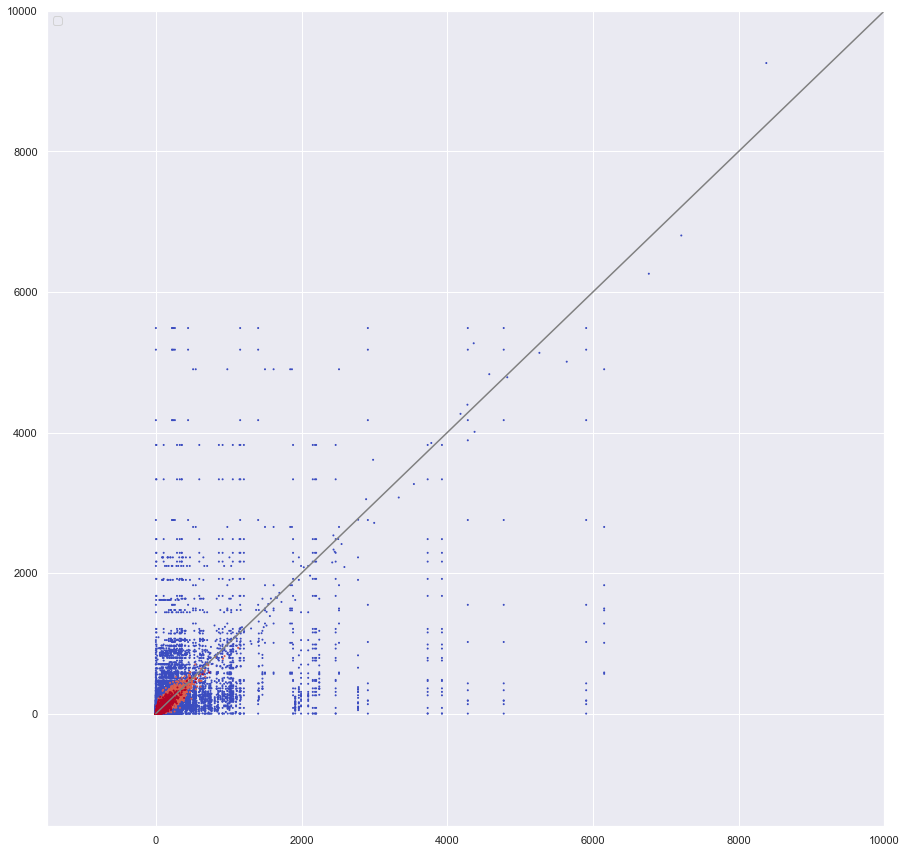

In [81]:
x=m.H0130005_y
y=m.H0130005_x
cc = m.SUMLEV

maxv = max(max(x),max(y))
plt.figure(figsize = (15, 15))
plt.scatter(x,y, cmap=plt.cm.coolwarm, c=cc, s=1)
plt.legend()
plt.ylim(top=10000)
plt.xlim(right=10000)
plt.plot( [0,maxv],[0,maxv] , color='grey')

In [22]:
len(dp_2010), len(sf1_2010)

(249, 83)

In [33]:
dp_2010.loc[dp_2010.COUNTY ==125].T

1212   1295   1378
FILEID    DHCST  DHCST  DHCST
STUSAB       US     US     US
SUMLEV       50     50     50
GEOCOMP      00     01     43
CHARITER      0      0      0
...         ...    ...    ...
H0130004  76027  72638   3389
H0130005  66021  62406   3615
H0130006  27576  26079   1497
H0130007   8943   8493    450
H0130008   3953   3746    207

[539 rows x 3 columns]

In [29]:
sf1_2010.COUNTY.unique()

array([  1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,
        23.,  25.,  27.,  29.,  31.,  33.,  35.,  37.,  39.,  41.,  43.,
        45.,  47.,  49.,  51.,  53.,  55.,  57.,  59.,  61.,  63.,  65.,
        67.,  69.,  71.,  73.,  75.,  77.,  79.,  81.,  83.,  85.,  87.,
        89.,  91.,  93.,  95.,  97.,  99., 101., 103., 105., 107., 109.,
       111., 113., 115., 117., 119., 121., 123., 125., 127., 129., 131.,
       133., 135., 137., 139., 141., 143., 145., 147., 149., 151., 153.,
       155., 157., 159., 161., 163., 165.])

In [27]:
list(sf1_2010.columns.values)

['FILEID',
 'STUSAB',
 'SUMLEV',
 'GEOCOMP',
 'CHARITER',
 'CIFSN',
 'LOGRECNO',
 'REGION',
 'DIVISION',
 'STATE',
 'COUNTY',
 'COUNTYCC',
 'COUNTYSC',
 'COUSUB',
 'COUSUBCC',
 'COUSUBSC',
 'PLACE',
 'PLACECC',
 'PLACESC',
 'TRACT',
 'BLKGRP',
 'BLOCK',
 'P0010001',
 'P0020001',
 'P0020002',
 'P0020003',
 'P0020004',
 'P0020005',
 'P0020006',
 'P0030001',
 'P0030002',
 'P0030003',
 'P0030004',
 'P0030005',
 'P0030006',
 'P0030007',
 'P0030008',
 'P0040001',
 'P0040002',
 'P0040003',
 'P0050001',
 'P0050002',
 'P0050003',
 'P0050004',
 'P0050005',
 'P0050006',
 'P0050007',
 'P0050008',
 'P0050009',
 'P0050010',
 'P0050011',
 'P0050012',
 'P0050013',
 'P0050014',
 'P0050015',
 'P0050016',
 'P0050017',
 'P0060001',
 'P0060002',
 'P0060003',
 'P0060004',
 'P0060005',
 'P0060006',
 'P0060007',
 'P0070001',
 'P0070002',
 'P0070003',
 'P0070004',
 'P0070005',
 'P0070006',
 'P0070007',
 'P0070008',
 'P0070009',
 'P0070010',
 'P0070011',
 'P0070012',
 'P0070013',
 'P0070014',
 'P0070015',
 'P00

In [14]:
dp_2010_140 = stdp['/dp_2010'].loc[stdp['/dp_2010'].SUMLEV ==140]
sf1_2010_140 = stsf1['/sf1_2010'].loc[stsf1['/sf1_2010'].SUMLEV ==140]

In [15]:
len(dp_2010_140), len(sf1_2010_140)

(2813, 2813)

In [12]:
dp_2010_150 = stdp['/dp_2010'].loc[stdp['/dp_2010'].SUMLEV ==150]
sf1_2010_150 = stsf1['/sf1_2010'].loc[stsf1['/sf1_2010'].SUMLEV ==150]


In [13]:
len(dp_2010_150), len(sf1_2010_150)

(8205, 8205)

In [ ]:
dp_2010 = stdp['/dp_2010'].loc[stdp['/dp_2010'].SUMLEV ==60]

In [ ]:
dpdata['H0130001']
sf1data['H0130001']

In [ ]:
dpdata.columns

In [ ]:
stsf1['/sf1_2010']

In [ ]:
x=stsf1['/sf1_2010']['H0130005']
y=stdp['/dp_2010']['H0130005']
maxv = max(max(x),max(y))
plt.scatter(x,y, s=0.2 )

plt.plot( [0,maxv],[0,maxv] , color='grey')